# Deep Learning Recommenders in TensorFlow

Dr. Nick Ball  
Data-Scientist-in-Residence, Paperspace

Last updated: Aug 09th 2021

This self-contained notebook shows the use of Paperspace Gradient to implement a recommender system using TensorFlow. It accompanies the 6-part blog series "Gradient End-to-End: A Recommender System using Notebooks and Workflows" on the [Paperspace blog](https://blog.paperspace.com), and the associated [Git Repository](https://github.com/gradient-ai/Deep-Learning-Recommender-TF).

The project includes these main highlights:

1. Show a real-world-style example of machine learning on Gradient
2. End-to-end dataflow incorporating both Gradient Notebooks and Workflows
3. Modern data science methodology based on Gradient's integrations with Git
4. Use TensorFlow 2 and TensorFlow Recommenders (TFRS) to train a recommender model that includes deep learning
5. Use training data that reflects what real-world projects deal with (not just demo data)
6. Construct a custom model using the full TensorFlow subclassing API
7. Show working hyperparameter tuning that improves the results
8. Deploy model using Gradient Deployments and its TensorFlow Serving integrations
9. Accompanying material: self-contained working Jupyter notebook, and Git repository
10. Aimed at a broad technical audience: data scientists who are not engineers, engineers who are not data scientists, those who span the two disciplines, and others

The project is not a complete enterprise-grade recommender system: they would typically take teams of several people months to construct, and result in an amount of code far greater than shown here, but it aims to be more than just a simple demonstration or toy model, by showcasing real data science techniques. In the Appendix we discuss some of the steps one might take to go from the project here to a full system, with a focus on Gradient's capabilities.

We assume the reader of this notebook is somewhat technical, but not necessarily an expert in recommender systems, deep learning, TensorFlow, or Paperspace.

## Note: Section 5 is coming soon!

Model deployment support in the Gradient product on public clusters is currently pending, expected in Sept. 2021. Therefore section 5 of the Notebook on model deployment is shown but will not yet run.


### Requirements

The notebook is designed to run on Paperspace Gradient

In the Gradient GUI, create a Notebook with the following settings:

 - Name = Deep Learning Recommender (or any allowed name)
 - Select a runtime = TensorFlow 2.4.1
 - Select a machine = C5 or P4000
 - Public/private = set to preferred option
 - Under Advanced options, change the Workspace URL field from https://github.com/gradient-ai/TF2.4.1.git to https://github.com/gradient-ai/Deep-Learning-Recommender-TF to point to this repository. The other options can remain the same.
 - Start the Notebook

Once the Notebook has started, click `deep_learning_recommender_tf.ipynb` to run in the usual way by clicking Run under each cell in turn.

Notebook creation can also be done on the command line if desired, via gradient notebooks create. For more details on Notebooks, see the documentation.

Alternatively, you can clone the Git repository and run in your own notebook setup

 - `git clone https://github.com/gradient-ai/Deep-Learning-Recommender-TF.git` (the repo is public, so Git's ssh command form is not required)
 - Be able to run Python 3, and import modules as in Section 2 below: Matplotlib, NumPy, TensorFlow 2, TFDS, TFRS
 - We use some notebook cell magic lines, such as `%matplotlib`

### Additional requirements to run Gradient Workflows and model deployment (sections 4.3+)

In addition to the above, to run the Gradient Workflows in section 4.3 and the model deployment in section 5 requires some more setup.

This step is optional:

 - Use or create a [Gradient Private Cluster](https://docs.paperspace.com/gradient/gradient-private-cloud/about/setup/managed-installation) and [get its ID](https://docs.paperspace.com/gradient/gradient-private-cloud/about/usage#finding-your-cluster-id). If no cluster ID is specified, the Gradient public cluster will be used.

These requirements will remain, being associated with Workflows as the enterprise-grade production part of Gradient:

 - [Create a project](https://docs.paperspace.com/gradient/get-started/managing-projects#create-a-project) and [get its ID](https://docs.paperspace.com/gradient/get-started/managing-projects#get-your-projects-id)
 - [Generate an API key](https://docs.paperspace.com/gradient/get-started/quick-start/install-the-cli#obtaining-an-api-key) for your project to allow access
 - [Store the API key](https://docs.paperspace.com/gradient/get-started/managing-projects/storing-an-api-key-as-a-secret) as a secret in your project

These steps will go away as the product matures around Workflows:

 - [Create the two workflows](https://docs.paperspace.com/gradient/explore-train-deploy/workflows/getting-started-with-workflows#creating-gradient-workflows) named `recommender-train-model` and `recommender-deploy-model`, and [get their IDs](https://docs.paperspace.com/gradient/explore-train-deploy/workflows/getting-started-with-workflows#running-your-first-workflow-run)
 - [Create an output dataset](https://docs.paperspace.com/gradient/data/data-overview/private-datasets-repository#creating-a-dataset-and-dataset-version) for the training workflow, named `recommender`
 
The create workflow step and create output dataset can be done via the GUI, or the [command line interface](https://docs.paperspace.com/gradient/get-started/quick-start/install-the-cli) (CLI). The commands for the latter look like

`gradient storageProviders list --apiKey <your API key>` (note the `storage provider ID` for **Gradient Managed** storage)  
`gradient datasets create --name recommender --storageProviderId <your storage provider ID> --apiKey <your API key>`  
`gradient workflows create --name Recommender-Train-Model --projectId <your project ID> --apiKey <your API key>`  
`gradient workflows create --name Recommender-Deploy-Model --projectId <your project ID> --apiKey <your API key>`

The usage of `--apiKey` on the command line is optional: you can also store a key in a JSON file, e.g., `~/.paperspace/config.json` to avoid having to add it to each command. Here we leave it present. Another option is the environment variable `PAPERSPACE_API_KEY`. See [connecting your account](https://docs.paperspace.com/gradient/get-started/quick-start/install-the-cli#connecting-your-account) for more details.

Note that one thing that is *not* required for this project, even in the current beta state, is any setup on your own machine, unless you choose to use the CLI. This is because the Workflows are invoked from this Notebook, via the SDK.

### Format of notebook text

The main text is shown as MarkDown, like this.

In [ ]:
# Optional extra information is in cell comments, like this.

### Recommenders

Recommender systems are widely used in modern artificial intelligence, most prominently in retail and entertainment content. However, many of these systems in businesses still use classical methods such as matrix factorization that may not capture all of the information now available.

The addition of the fully nonlinear mappings allowed by machine learning, for example deep learning neural network layers, can improve the performance of recommender systems by both capturing more of the complex patterns of information that are present, and by making it easier to add new information in the form of further data feature columns, such as detailed text descriptions or reviews, multiple user and item information columns, or timestamps.

Here, we use the new TensorFlow Recommenders library to show how the addition of deep learning to a recommender model improves its performance.

# Contents

1. Introduction: Recommender systems and deep learning
2. Setup
3. Preparing the dataset
4. Build the recommender models
5. Deploy the final model
6. Conclusions

Next Steps  
Appendices

## 1: Introduction: Recommender systems and deep learning

A good way to describe most recommender systems is:

*Present suggested new items to a user that users similar to them already liked.*

This is on the assumption that if users similar to them liked something, there is a better-than-random chance that they will like it too.

The short sentence above involves several concepts, including information about a user, how to measure if they are similar to another user, what items the other users liked, how to choose candidate items to present from the whole list, and how to rank those choices.

(There are further ideas as well, such as whether a user rated an item explicitly or just implicitly liked it by watching or buying it, and using other similarities such as item-item as well as user-user similarity.)

Here, we use the well-known MovieLens dataset, containing information about which movies users watched, along with details of the movies, the users, and the times of viewing. The idea is to present to a user suggested movies that they might like to watch next.

While not a huge modern dataset with millions of viewings from millions of users, it has been widely used, and is "real enough" to show both how deep learning can improve recommender models, and how to set up and end-to-end data science workflow.

The content of this notebook is based on the tutorials of the [TensorFlow Recommenders (TFRS) library](https://www.tensorflow.org/recommenders), modified to include more real-world data science steps, and showing a model being deployed into production.

As described there, recommender models commonly consist of two parts:

 - Retrieval, which selects possible candidates from the whole list of items that could be recommended, in this case being movies the user might be interested in
 - Ranking, which narrows down this list to a refined set of items to recommend

We concentrate on the ranking portion, showing how the addition of deep learning layers, data features, and hyperparameter tuning, improves the performance of the model.

We then show how the resulting model can be easily deployed with Gradient Deployments.

The concentration on just one part of the models to be built is so that we can show more fully realized data science steps, the end-to-end process using both Gradient Notebooks and Workflows, and some of the corresponding functionaity, without the project becoming overly long or repetitive.

## 2: Setup

This project uses [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets) and the TensorFlow Recommenders library (TFRS) in addition to the basic TensorFlow 2 and Python 3.

TFRS was created as a separate library because recommender systems typically do not correspond to the simple setup of supervised learning models, but have a more complex arrangement of processing steps associated with them. So rather than using a few layers in the high-level TensorFlow Keras Sequential or [Functional](https://www.tensorflow.org/guide/keras/functional) APIs, they need the custom model and custom layer setup in the lower level representation of writing the model classes and subclasses directly.

However, recommenders do contain their own common components, such as the FactorizedTopK performance metric for retrieval, that mean usage of a library is considerably more convenient than writing something from scratch in TensorFlow.

We use TensorFlow Datasets as the emphases in this project are recommenders, Gradient functionality, end-to-end, and showing some model tuning, rather than data gathering, cleaning, and preparation. Of course, in a full enterprise system this would be a more prominent aspect of the dataflow.

Let's install TFDS, TFRS, and import these and the Python modules that we need.

In [ ]:
# Currently the notebook is using pip install, which would not be ideal in a production environment.
# This is because the install changes the environment and the versions of libraries being installed are
# not necessarily fixed, meaning the environment is not fixed and hence reproducibility is not guaranteed.
# One could use requirements.txt, but this also does not necessarily fix things due to secondary dependencies.

# Various solutions exist, but for rigorous work, Gradient allows the user to build a custom container
# containing the correct dependencies, which removes the need for pip install.

# Here, the container we use fixes versions, except for TFDS and TFRS, whose versions we therefore fix.

!pip install --upgrade pip
!pip install -q tensorflow-recommenders==0.4.0
!pip install -q --upgrade tensorflow-datasets==4.2.0

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient-utils 0.3.2 requires numpy==1.18

In [ ]:
import os
import platform

# This is Python's function for more nicely or compactly printing variables or data
import pprint

# Python 3 allows hints on variable types to be given
# Here they are used in the model class definitions
from typing import Dict, Text

# NumPy is used, e.g., for viewing the data in TensorFlow tensors
# TensorFlow tensors are built on NumPy arrays
import numpy as np

# This allows simple inline plots of, e.g., model training history
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') # Following TFRS tutorials

# TensorFlow, TFDS, TFRS
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

We can see some basic information about the versions of software that we are using. In principle, the container could be accessed to find out more.

In [ ]:
print('NumPy version: {}'.format(np.__version__))
print('Python version: {}'.format(platform.python_version()))
print('TensorFlow version: {}'.format(tf.__version__))
print('TensorFlow Datasets version: {}'.format(tfds.__version__))
print('TensorFlow Recommenders version: {}'.format(tfrs.__version__))

NumPy version: 1.19.5
Python version: 3.6.9
TensorFlow version: 2.4.0
TensorFlow Datasets version: 4.2.0
TensorFlow Recommenders version: v0.4.0


We can see if GPUs, etc., are available, or just CPU. Here we do not currently specify devices other than the default, as the processing run is not large enough to require a GPU.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15123098248465724941
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7810874080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13217360528687930248
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:00:05.0, compute capability: 6.1"
]


## 3: Preparing the dataset

Load the MovieLens data from TensorFlow Datasets.

In [ ]:
# This loads the data from the official TensorFlow datasets repository
# at https://www.tensorflow.org/datasets/catalog/movielens
# The -ratings suffix indicates that we are loading the dataset with the
# movies data joined to the ratings data

ratings_raw = tfds.load('movielens/100k-ratings', split='train')

In [ ]:
# It is loaded as a TensorFlow PrefetchDataset
ratings_raw

<PrefetchDataset shapes: {bucketized_user_age: (), movie_genres: (None,), movie_id: (), movie_title: (), raw_user_age: (), timestamp: (), user_gender: (), user_id: (), user_occupation_label: (), user_occupation_text: (), user_rating: (), user_zip_code: ()}, types: {bucketized_user_age: tf.float32, movie_genres: tf.int64, movie_id: tf.string, movie_title: tf.string, raw_user_age: tf.float32, timestamp: tf.int64, user_gender: tf.bool, user_id: tf.string, user_occupation_label: tf.int64, user_occupation_text: tf.string, user_rating: tf.float32, user_zip_code: tf.string}>

Data science workflows, especially in the experimental and model training stage as here, should contain a strong component of viewing the actual data throughout the analysis. This is both for the understanding of the experimenter, other readers, and for sanity checking.

Here we see that various columns (features) are available, including information about the user, the movie they watched, and outcomes such as the user's rating of the movie.

It is important to distinguish between information that is available before a user watches a movie from that which is only available after, as the latter cannot be used as a feature for training a recommender model. This is because the data to be fed into it when it is deployed must be available before the user has watched the movie that is being recommended to them.

In this case, the requirement manifests as the `user_rating` column being a training target and not a feature, and a timestamp column that should be normalized into something that is cyclical like a day of week / month / year, and not an absolute date. Such a date won't come around again in the future when the model has been deployed on unseen data.

We also immediately see issues with the data that may manifest further along in the dataflow, such as some of the columns being byte-encoded (strings like `b'357'` instead of just `'357'`). If the setup of TensorFlow Serving plus the RESTful API is to be used for deployment, these will have to be converted to be able to be represented in JSON for passing to the model when it is deployed.

The end-to-end mentality of having deployment in scope from the start, enabled by Gradient, has encouraged us to look for and notice these issues right here, rather than spending time training the model and only then noticing them. The latter approach could result in signficant wasted effort if it turns out that the deployment issues are not solvable.

The top 2 rows of data are shown.

In [ ]:
# Just saying print(ratings) results in the output <PrefetchDataset shapes: ... as above
# So the data is extracted from the TensorFlow tensor format using NumPy

for x in ratings_raw.take(2).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'bucketized_user_age': 25.0,
 'movie_genres': array([ 4, 14]),
 'movie_id': b'709',
 'movie_title': b'Strictly Ballroom (1992)',
 'raw_user_age': 32.0,
 'timestamp': 875654590,
 'user_gender': True,
 'user_id': b'92',
 'user_occupation_label': 5,
 'user_occupation_text': b'entertainment',
 'user_rating': 2.0,
 'user_zip_code': b'80525'}


TensorFlow's `.map()` applies the function in the brackets to each element of a dataset, so with the lambda inline Python function we can reduce the data down to just the columns that we are going to use. Currently these are the movie title, the time of viewing, the user who viewed it, and their rating of the movie.

In [ ]:
ratings = ratings_raw.map(lambda x: {
    'movie_title': x['movie_title'],
    'timestamp': x['timestamp'],
    'user_id': x['user_id'],
    'user_rating': x['user_rating']
})

We perform the canonical 80:20 random split of 80% training data and 20% testing data, with in turn 20% of the training data being used for model validation.

As mentioned above, we want to avoid leakage of information from the testing set into the training and validation sets, so we split by timestamp. The testing data comes from later times than the training & validation data. Currently the timestamp used is still absolute rather than cyclic (day of week, month of year, etc.), but that would likely just dampen its utility as a feature, so long as the model is not overfitting to it.

TensorFlow allows global and local random seeds to be set, which can ensure, e.g., that we get the same 80:20 split each time here.

However, randomness remains in the machine learning models when they are run, which is harder to remove. We have not attempted to do so in this project so results may vary when the notebook is rerun, but they should show the same overall pattern, i.e., they are statistically reproducible even if not exactly reproducible.

In [ ]:
# Get times as a list so we can get the minimum and maximum time values
# In the original data they are dictionaries, so a list is needed
# Following the TFRS deep model tutorial (https://www.tensorflow.org/recommenders/examples/deep_recommenders)
# a quick way to do this is

timestamps = np.concatenate(list(ratings.map(lambda x: x['timestamp']).batch(100)))

In [ ]:
# Get minimum and maximum time values

max_time = timestamps.max()
min_time = timestamps.min()

print('Minimum time value = {}'.format(min_time))
print('Maximum time value = {}'.format(max_time))

Minimum time value = 874724710
Maximum time value = 893286638


In [ ]:
# Get 60th & 80th percentile times

sixtieth_percentile = min_time + 0.6*(max_time - min_time)
eightieth_percentile = min_time + 0.8*(max_time - min_time)

print('60th percentile time = {}'.format(sixtieth_percentile))
print('80th percentile time = {}'.format(eightieth_percentile))

60th percentile time = 885861866.8
80th percentile time = 889574252.4


In [ ]:
# Filter original data so that

# Training set <= 60th percentile time
# 60th < Validation set <= 80th
# Testing set > 80th

train =      ratings.filter(lambda x: x['timestamp'] <= sixtieth_percentile)
validation = ratings.filter(lambda x: x['timestamp'] > sixtieth_percentile and x['timestamp'] <= eightieth_percentile)
test =       ratings.filter(lambda x: x['timestamp'] > eightieth_percentile)

In [ ]:
# We are splitting on time percentiles and not row percentiles,
# which means that we have assumed the times are roughly evenly distributed

# So check the number of rows in the training, validation, and testing sets is as expected

# We could also do row percentiles, which would involve sorting the data by time then shuffling after splitting
# As written, the counting is a little slow, but .__len__() doesn't work on the FilterDataset from above

# The lengths sum to the number of rows in the original data, currently 100,000, as expected

ntimes_tr = 0
ntimes_va = 0
ntimes_te = 0

for x in train.take(-1).as_numpy_iterator():
    ntimes_tr += 1

for x in validation.take(-1).as_numpy_iterator():
    ntimes_va += 1

for x in test.take(-1).as_numpy_iterator():
    ntimes_te += 1
    
print('Number of rows in training set = {}'.format(ntimes_tr))
print('Number of rows in validation set = {}'.format(ntimes_va))
print('Number of rows in testing set = {}'.format(ntimes_te))
print('Total number of rows = {}'.format(ntimes_tr + ntimes_va + ntimes_te))

Number of rows in training set = 65336
Number of rows in validation set = 15778
Number of rows in testing set = 18886
Total number of rows = 100000


In [ ]:
# A validation set is created here because validation_split in model.fit() 
# is not supported for datasets - its input would have to be tensors
# ( [1] ValueError: `validation_split` is only supported for Tensors or NumPy arrays, 
# found following types in the input: 
# [<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'>] )

train = train.shuffle(ntimes_tr)
validation = validation.shuffle(ntimes_va)
test = test.shuffle(ntimes_te)

We also need to extract from the data the list of unique user IDs and unique movie titles.

This is because these variables are categorical, and when we use embedding vectors (see below), they map each category onto its own vector.

In [ ]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x['movie_title'])
user_ids = ratings.batch(1_000_000).map(lambda x: x['user_id'])

In [ ]:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## 4: Build the recommender models

As mentioned above, recommender systems are often composed of a retrieval model and a ranking model. We will be focusing on the ranking model.

We will build two models:

 - Basic ranking
 - Tuned ranking

and show that the tuned ranking model gives the best performance. This shows the importance of tuning and not just engineering a pipeline using a model off-the-shelf.

Recommenders are more complex than basic supervised models, so in the hierarchy of increased flexibility but decreased simplicity or ease of use from the Keras Sequential API, through the Keras functional API, to full definition of model classes and subclasses, the latter approach is used. The classes don't have to be written entirely from scratch, however, as the TFRS library contains various convenience classes and functions, and higher level Keras models and layers can still be used when they fit the purpose.

In these models, some of the feature preprocessing can be incorporated as part of the model. This reduces the chance of errors being introduced when it is deployed in production in a different place from where it was trained, because the preprocessing of data from the raw inputs to those correct for the model does not need to be duplicated.

The various preprocessing steps and modeling components are combined into a recommender model that can then be trained. The model is described by a Python class that inherits from the TFRS base class.

It includes:

 - Movie embeddings
 - User ID embeddings
 - Deep learning layer to compute the rankings
 - Task layer to compute mean squared error
 - The `call()` method
 - The `compute_loss()` method

The movie and user ID *embeddings* are using this common method of reducing a column that contains a large number of unique categories to something more manageable. The raw categories get mapped onto integers (known as a vocabulary), which in turn are converted to embeddings. The embedding itself is a vector that represents the mapping from a space with many dimensions (the number of categories) to a continuous vector space with a much lower dimension, e.g., 32.

The deep learning layer is a typical set of densely connected layers (every neuron connected to all the others) that allows an arbitrary nonlinear mapping between the inputs and outputs. Deep learning is typically more compute-intensive, but for ranking in a full production system only a small subset of the movies are being used, having been selected by the retrieval model, so this helps.

The task layer computes mean squared error between a given ground truth target and the model's prediction. This feeds into `compute_loss()`. `Task` is a TFRS layer that is combining computing the loss, i.e., the measure by which the model training is iterated, and the metric, the measure by which the model performance is reported to the human user. In this case the loss is mean squared error and the metric is root mean squared error, so they are quite similar.

The `compute_loss()` method measures how well the model is performing after each iteration of training. This is a built-in method to TFRS and is therefore automatically called during model training with a `tfrs.models.Model` class (the training loop).

The `call()` method executes the various steps when the model is run, and is important for the model to be able to be saved for later deployment.

The overall result is that for a given user ID and movie title fed to the model, the output is a prediction of what rating that user would give to that movie if they were to watch it. The movies with the highest predicted ratings therefore become the recommendations for that user.

### 4.1: Basic ranking model

The basic model shows what happens when a model is set up with some default parameters, without attempting to tune any of them.

The model is similar to the one in the [TFRS multitask tutorial](https://www.tensorflow.org/recommenders/examples/multitask), here doing a single task.

In [ ]:
class MovielensModelBasicRanking(tfrs.models.Model):

    def __init__(self) -> None:
        super().__init__()
        embedding_dimension = 32

        # The embeddings use Keras's preprocessing layers

        # Embeddings for movies
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])

        # Embeddings for users
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Predicted ratings
        # This is where deep learning is being used in the recommender system
        # The predictions are output by the final layer, hence its size of 1

        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        # Ranking is written as a TFRS task
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    # The call method allows the model to be run, and saved
    # The embeddings are passed into the model
    # The embeddings and predicted rating are returned

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_embeddings = self.user_model(features['user_id'])
        movie_embeddings = self.movie_model(features['movie_title'])

        return (
            user_embeddings,
            movie_embeddings,
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            ),
        )

    # This is the TFRS built-in method that computes the model loss function during training
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop('user_rating')
        user_embeddings, movie_embeddings, rating_predictions = self(features)

        rating_loss = self.task(
            labels=ratings,
            predictions=rating_predictions,
        )

        return rating_loss

As at the start of the dataflow, we should view the data at the training stage.

The training data is quite similar to the original loaded data, now just movie title, timestamp, user ID, and rating.

In [ ]:
# Format is now a TensorFlow ShuffleDataset
train

<ShuffleDataset shapes: {movie_title: (), timestamp: (), user_id: (), user_rating: ()}, types: {movie_title: tf.string, timestamp: tf.int64, user_id: tf.string, user_rating: tf.float32}>

In [ ]:
for x in train.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'movie_title': b'Local Hero (1983)',
 'timestamp': 883948457,
 'user_id': b'846',
 'user_rating': 4.0}
{'movie_title': b'Sudden Death (1995)',
 'timestamp': 880394088,
 'user_id': b'374',
 'user_rating': 3.0}
{'movie_title': b'Beverly Hills Ninja (1997)',
 'timestamp': 880696679,
 'user_id': b'699',
 'user_rating': 1.0}


The model performance, especially at scale, can be improved by caching the data into memory.

It is also important that the data rows are in a random order. This is because many parts of machine learning algorithms are assuming that each data row is independent of those around it.

An example of that is batching the data, which is also done here. Batching causes consecutive elements to be combined into batches, and so if there were, say, some periodicity in the data, it could interact with the batch size and produce highly non-random samples.

Note that since a batch size may not divide perfectly into the number of rows in a dataset (or when data is being fed into the system a batch may not be full), its shape may not be known for every batch, and is therefore given as None.

In [ ]:
cached_train = train.shuffle(ntimes_tr).batch(8192).cache()
cached_validation = validation.shuffle(ntimes_va).batch(8192).cache()
cached_test = test.batch(4096).cache()

Since the actual data being fed into the model is the cached and batched set, this should be viewed too. We can see that it is now batched and the batches are formed by arrays.

In [ ]:
# The shape could be changed, e.g., from None to 8192 by adding drop_remainder=True to the .batch() line above
cached_train

<CacheDataset shapes: {movie_title: (None,), timestamp: (None,), user_id: (None,), user_rating: (None,)}, types: {movie_title: tf.string, timestamp: tf.int64, user_id: tf.string, user_rating: tf.float32}>

In [ ]:
for x in cached_train.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'movie_title': array([b'Wizard of Oz, The (1939)', b'1-900 (1994)',
       b'Independence Day (ID4) (1996)', ...,
       b'Hunt for Red October, The (1990)',
       b'Big Blue, The (Grand bleu, Le) (1988)',
       b'Speed 2: Cruise Control (1997)'], dtype=object),
 'timestamp': array([877196174, 878962200, 879222698, ..., 885062919, 885816915,
       882659211]),
 'user_id': array([b'331', b'181', b'552', ..., b'513', b'452', b'276'], dtype=object),
 'user_rating': array([3., 1., 4., ..., 5., 5., 2.], dtype=float32)}
{'movie_title': array([b'Some Kind of Wonderful (1987)', b'Batman Returns (1992)',
       b'Scream (1996)', ..., b'To Kill a Mockingbird (1962)',
       b'Fear (1996)', b'My Fellow Americans (1996)'], dtype=object),
 'timestamp': array([875983023, 878347915, 882818604, ..., 879448475, 878848369,
       874953595]),
 'user_id': array([b'472', b'44', b'668', ..., b'615', b'749', b'130'], dtype=object),
 'user_rating': array([5., 2., 4., ..., 5., 4., 2.], dtype=float32)}
{'m

#### 4.1.1: Train and evaluate the basic ranking model

Train the model, outputting the accuracy on the training set and also on the validation set.

In [ ]:
model_br = MovielensModelBasicRanking()

In [ ]:
model_br.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
history_br = model_br.fit(cached_train, epochs=3, validation_data=cached_validation)

Epoch 1/3
8/8 [==============================] - 15s 1s/step - root_mean_squared_error: 2.1538 - loss: 4.2543 - regularization_loss: 0.0000e+00 - total_loss: 4.2543 - val_root_mean_squared_error: 1.1547 - val_loss: 1.3360 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3360
Epoch 2/3
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.1460 - loss: 1.3241 - regularization_loss: 0.0000e+00 - total_loss: 1.3241 - val_root_mean_squared_error: 1.2378 - val_loss: 1.5364 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.5364
Epoch 3/3
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.1957 - loss: 1.4229 - regularization_loss: 0.0000e+00 - total_loss: 1.4229 - val_root_mean_squared_error: 1.1992 - val_loss: 1.4418 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.4418


The full model history contains quite a lot of information:

 - Loss = the value of the loss function
 - Regularization loss = 0, since we are not applying regularization in the basic model
 - Root mean squared error = the model performance metric we are recording
 - Total loss = loss + regularization loss, so the same as loss here
 - The same four again, but for the validation set instead of the training set

In [ ]:
pprint.pprint(history_br.history)

{'loss': [1.2601068019866943, 1.4078688621520996, 1.3704522848129272],
 'regularization_loss': [0, 0, 0],
 'root_mean_squared_error': [2.1538093090057373,
                             1.1459987163543701,
                             1.1956913471221924],
 'total_loss': [1.2601068019866943, 1.4078688621520996, 1.3704522848129272],
 'val_loss': [1.335972547531128, 1.5363689661026, 1.441826581954956],
 'val_regularization_loss': [0, 0, 0],
 'val_root_mean_squared_error': [1.1546682119369507,
                                 1.237779140472412,
                                 1.199165940284729],
 'val_total_loss': [1.335972547531128, 1.5363689661026, 1.441826581954956]}


We can report the most relevant numbers from the history, and make a simple plot of the tuning. Here we look at the value of the performance metric.

The model has a performance of root mean squared error (RMSE) between predicted and true user ratings of movies of about 1.1, and the value is similar for training and validation, indicating that with the short training duration here the model has not overfit.

A more sophisticated option than making these plots would be to load and use TensorBoard, but the overall conclusion drawn would be the same.

In [ ]:
rmse_br = history_br.history['root_mean_squared_error'][-1]
print(f'Root mean squared error in user rating from training: {rmse_br:.2f}')

val_rmse_br = history_br.history['val_root_mean_squared_error'][-1]
print(f'Root mean squared error in user rating from validation: {val_rmse_br:.2f}')

Root mean squared error in user rating from training: 1.20
Root mean squared error in user rating from validation: 1.20


In [ ]:
# This sets up the x axis of the plot
num_validation_runs = len(history_br.history['root_mean_squared_error']) # Or val_ ; is same here

# The TFRS tutorials include values of validation frequency >1 to accommodate training runs where it was set >1 for faster training
# Here it is left as 1
validation_freq = 1
epochs = [(x + 1) * validation_freq for x in range(num_validation_runs)] # E.g., 3,6,9 ... if validation_freq = 3

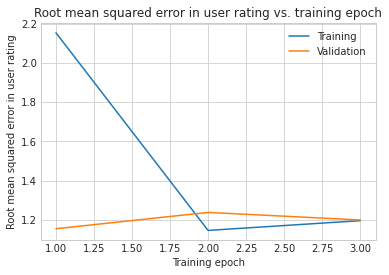

In [ ]:
# Simple plot with Matplotlib
plt.plot(epochs, history_br.history['root_mean_squared_error'], label='Training')
plt.plot(epochs, history_br.history['val_root_mean_squared_error'], label='Validation')
plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.legend()

We can see the model architecture via `.summary()`, showing the deep learning layers. Even for this small model, the number of parameters is over 100,000, which is greater than the number of movies in the dataset. This shows the importance of setting up the model to not overfit when trained for longer, which we will do in the tuned model below.

In [ ]:
model_br.summary()

Model: "movielens_model_basic_ranking"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32)                53280     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                30208     
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 33153     
_________________________________________________________________
ranking (Ranking)            multiple                  2         
Total params: 116,643
Trainable params: 116,641
Non-trainable params: 2
_________________________________________________________________


The model's performance can be measured on unseen test data for which what the user did in fact rate the movie (the ground truth) is still available.

It is important that the test data is not used as part of the model training or validation, either directly (overlap between training and testing data), or indirectly (performance on testing data being used to influence subsequent training runs).

Both of these would produce a result biased high in performance compared to expected performance on new unseen data when the model is deployed in production.

As expected following the validation, the RMSE on the unseen testing set is also approximately 1.1.

In [ ]:
eval_br = model_br.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 6s 13ms/step - root_mean_squared_error: 1.1413 - loss: 1.3029 - regularization_loss: 0.0000e+00 - total_loss: 1.3029


In [ ]:
eval_br

{'root_mean_squared_error': 1.1412544250488281,
 'loss': 1.30448579788208,
 'regularization_loss': 0,
 'total_loss': 1.30448579788208}

In [ ]:
rmse_eval_br = eval_br['root_mean_squared_error']
print(f'Root mean squared error in user rating from evaluation: {rmse_eval_br:.2f}')

Root mean squared error in user rating from evaluation: 1.14


Calling `.predict()` on the model, i.e., sending it data from the testing set in the same manner as new data would be sent to it when deployed, yields the user & movie embeddings for each new data point, and the predicted user ratings for those data points.

Here the testing data still has ground truth user ratings that these predictions can be compared to (as in evaluate, above), but of course in production the return will be just the predicted ratings (and embeddings, in this case).

In [ ]:
# As written, the model prediction returns both the embeddings and predicted ratings
model_br.predict(cached_test)

(array([[ 0.01111712,  0.0342272 , -0.03558037, ...,  0.02093932,
          0.0499819 ,  0.03310004],
        [ 0.03682995, -0.00292829, -0.01203686, ..., -0.02694032,
         -0.04817913, -0.01506655],
        [-0.02005151,  0.04311559,  0.02915088, ..., -0.01426794,
         -0.02800677,  0.00755465],
        ...,
        [ 0.00597314, -0.00417596, -0.01312952, ...,  0.04654224,
          0.02042881, -0.00455733],
        [ 0.01837805,  0.03272862, -0.00753467, ..., -0.00106486,
          0.00688084, -0.01778299],
        [ 0.01170737, -0.02230951,  0.02672443, ...,  0.04496305,
          0.01577738,  0.04709944]], dtype=float32),
 array([[-0.01685286, -0.0241822 , -0.01624944, ...,  0.02533602,
         -0.03852903, -0.00798178],
        [ 0.01273345,  0.04116427, -0.01204921, ...,  0.04427261,
          0.00770494,  0.04154444],
        [-0.02010706,  0.00707144,  0.01014473, ...,  0.0358832 ,
         -0.02845538, -0.04785193],
        ...,
        [ 0.03443922,  0.00560572, -0.0

### 4.2: Tuned ranking model

For most machine learning models, a model that has not had its hyperparameters tuned is unlikely to be giving best performance. It would be a bit like choosing random clothes from a store instead of clothes that are your size.

The combination of being able to be tuned to higher performance, and the ability to easily add new training set features of many different kinds (categorical, numerical, text, time series, etc.) is what enables deep learning (or other nonlinear ML such as decision trees) to outperform classical non-ML methods on complex data. As written, the deep learning layers component of the model can be whatever arbitrary set of layers, so long as it outputs a single rating at the end.

Here we perform some basic tuning on the neural network layer by training it for more epochs and allowing its initial learning rate to vary. We also add regularization to help avoid overfitting that could result from longer training.

For more extensive tuning, other parameters can be tuned similarly, including within the network, e.g., size & number of layers, and within the whole model, such as the number of dimensions in the embeddings.

If one plans to do more extensive tuning, then for a recommender system like this one, it also makes sense to include more features, such as user age, do more feature engineering, such as cyclic and not absolute times like day of week, and to build more complex models like multitask and deep cross networks as in the TFRS tutorials. To keep this showcase to a manageable length, we do not attempt all of that here.

In [ ]:
# This model is similar to the basic model, but L2 regularization has been added

class MovielensModelTunedRanking(tfrs.models.Model):

    def __init__(self) -> None:
        super().__init__()
        embedding_dimension = 32

        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])

        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Regularization is added here
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dense(1)
        ])

        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        user_embeddings = self.user_model(features['user_id'])
        movie_embeddings = self.movie_model(features['movie_title'])

        return (
            user_embeddings,
            movie_embeddings,
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop('user_rating')
        user_embeddings, movie_embeddings, rating_predictions = self(features)

        rating_loss = self.task(
            labels=ratings,
            predictions=rating_predictions,
        )

        return rating_loss

When tuning hyperparameters using the grid approach, it is common to test a range of values across a logarithmic scale, then fine-tune by using a linear scale in the range suggested to be best by the logarithmic scale. (For example, try learning rates of 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, and 1, and if the performance is best for 0.1, then try 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, and 0.15.)

Here we only show a small number of values to avoid excessive processing time.

Let's set the values we are tuning so they are not hidden in the calls to the model.

In [ ]:
learning_rates_logarithmic = [0.001, 0.01, 0.1, 1]
epochs = 30

Run the logarithmic grid. As with the basic model, the indicator of performance is the RMSE error, shown in the output.

In [ ]:
# Store the training histories in a dictionary
# This can probably be done better or more securely than here, because we are creating 
# variable names from values, but it serves the purpose here of plotting the tuning

histories_tr = {}

# For each learning rate:

# - Create an instance of the model class that can be used as the model
# - Compile the model to set its initial parameters
# - Train the model using .fit, minimizing the loss on the neural network predictions of the user ratings

for val in learning_rates_logarithmic:
    print('Learning rate = {}'.format(val))
    model_tr = MovielensModelTunedRanking()
    model_tr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=val))

    lr = str(val)
    histories_tr[lr] = model_tr.fit(cached_train, epochs=epochs, validation_data=cached_validation)

Learning rate = 0.001
Epoch 1/30
8/8 [==============================] - 1s 30ms/step - root_mean_squared_error: 3.7003 - loss: 13.6703 - regularization_loss: 2.0611 - total_loss: 15.7314 - val_root_mean_squared_error: 3.5970 - val_loss: 12.9255 - val_regularization_loss: 2.0600 - val_total_loss: 14.9856
Epoch 2/30
8/8 [==============================] - 0s 15ms/step - root_mean_squared_error: 3.6684 - loss: 13.4396 - regularization_loss: 2.0590 - total_loss: 15.4987 - val_root_mean_squared_error: 3.5708 - val_loss: 12.7386 - val_regularization_loss: 2.0580 - val_total_loss: 14.7966
Epoch 3/30
8/8 [==============================] - 0s 34ms/step - root_mean_squared_error: 3.6437 - loss: 13.2602 - regularization_loss: 2.0570 - total_loss: 15.3172 - val_root_mean_squared_error: 3.5479 - val_loss: 12.5760 - val_regularization_loss: 2.0560 - val_total_loss: 14.6319
Epoch 4/30
8/8 [==============================] - 0s 17ms/step - root_mean_squared_error: 3.6215 - loss: 13.0997 - regularization

As above, we can view and plot the tuning history, now for multiple hyperparameter tuning grid points.

In [ ]:
# All 4 histories
histories_tr

{'0.001': <tensorflow.python.keras.callbacks.History at 0x7f5ae843d630>,
 '0.01': <tensorflow.python.keras.callbacks.History at 0x7f5ae83b0a58>,
 '0.1': <tensorflow.python.keras.callbacks.History at 0x7f5afc087ac8>,
 '1': <tensorflow.python.keras.callbacks.History at 0x7f5ae872bac8>}

In [ ]:
# History for learning rate 0.1
pprint.pprint(histories_tr['0.1'].history, compact=True)

{'loss': [1.762627124786377, 1.27882719039917, 1.2089080810546875,
          1.1910356283187866, 1.1852569580078125, 1.1688036918640137,
          1.1348143815994263, 1.1025407314300537, 1.0754719972610474,
          1.0513532161712646, 1.028888463973999, 1.0077794790267944,
          0.9882305264472961, 0.9706097841262817, 0.9550227522850037,
          0.9414154887199402, 0.9296673536300659, 0.9195032119750977,
          0.9106879234313965, 0.9030314683914185, 0.8963359594345093,
          0.8904510140419006, 0.8852168321609497, 0.8805525302886963,
          0.8763761520385742, 0.8726167678833008, 0.8692119121551514,
          0.8661321997642517, 0.8633233904838562, 0.8607590198516846],
 'regularization_loss': [1.8833727836608887, 1.709684133529663,
                         1.5512652397155762, 1.4084283113479614,
                         1.2802670001983643, 1.1646971702575684,
                         1.0602525472640991, 0.9661356806755066,
                         0.8814136385917664,

In [ ]:
for val in learning_rates_logarithmic:
    lr = str(val)

    rmse_tr = histories_tr[lr].history['root_mean_squared_error'][-1]
    print('Root mean squared error in user rating from training   for learning rate {} = {}'.format(lr, rmse_tr))

    val_rmse_tr = histories_tr[lr].history['val_root_mean_squared_error'][-1]
    print('Root mean squared error in user rating from validation for learning rate {} = {}'.format(lr, val_rmse_tr))

Root mean squared error in user rating from training   for learning rate 0.001 = 3.02431321144104
Root mean squared error in user rating from validation for learning rate 0.001 = 2.9313621520996094
Root mean squared error in user rating from training   for learning rate 0.01 = 1.0800449848175049
Root mean squared error in user rating from validation for learning rate 0.01 = 1.1250864267349243
Root mean squared error in user rating from training   for learning rate 0.1 = 0.9358880519866943
Root mean squared error in user rating from validation for learning rate 0.1 = 1.0395591259002686
Root mean squared error in user rating from training   for learning rate 1 = 1.4039241075515747
Root mean squared error in user rating from validation for learning rate 1 = 4.874517440795898


In [ ]:
num_validation_runs = len(histories_tr['0.1'].history['root_mean_squared_error']) # Or any of the learning rates; they are all the same
validation_freq = 1
epochs_x = [(x + 1) * validation_freq for x in range(num_validation_runs)]

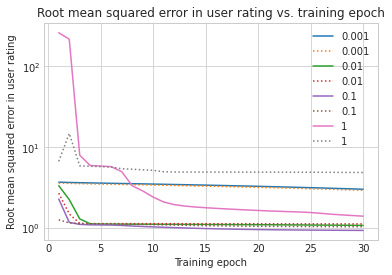

In [ ]:
for val in learning_rates_logarithmic:
    lr = str(val)
    plt.plot(epochs_x, histories_tr[lr].history['root_mean_squared_error'], label=lr)
    plt.plot(epochs_x, histories_tr[lr].history['val_root_mean_squared_error'], label=lr, linestyle='dotted')

plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.yscale('log')
plt.legend()

It looks like learning rates closer in magnitude to 0.1 than 0.01 or 1 are best, so we zoom in on those.

Again a production system would test more values so the results are less noisy, but this shows the idea.

The RMSE has improved from about 1.1 in the basic model to about 0.9 here, although a little higher on the validation set.

In [ ]:
# Here we start a new dictionary of training histories, but these could also be appended to the above one
histories_tr_li = {}

# Learning rate linear grid
learning_rates_linear = [0.05, 0.1, 0.15]

for val in learning_rates_linear:
    print('Learning rate = {}'.format(val))
    model_tr = MovielensModelTunedRanking()
    model_tr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=val))

    lr = str(val)
    histories_tr_li[lr] = model_tr.fit(cached_train, epochs=epochs, validation_data=cached_validation)

Learning rate = 0.05
Epoch 1/30
8/8 [==============================] - 1s 30ms/step - root_mean_squared_error: 2.1155 - loss: 4.1128 - regularization_loss: 2.0002 - total_loss: 6.1129 - val_root_mean_squared_error: 1.1633 - val_loss: 1.3542 - val_regularization_loss: 1.9563 - val_total_loss: 3.3105
Epoch 2/30
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.1256 - loss: 1.2646 - regularization_loss: 1.9082 - total_loss: 3.1728 - val_root_mean_squared_error: 1.1419 - val_loss: 1.3045 - val_regularization_loss: 1.8598 - val_total_loss: 3.1643
Epoch 3/30
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.1172 - loss: 1.2469 - regularization_loss: 1.8152 - total_loss: 3.0621 - val_root_mean_squared_error: 1.1341 - val_loss: 1.2862 - val_regularization_loss: 1.7684 - val_total_loss: 3.0546
Epoch 4/30
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.1181 - loss: 1.2494 - regularization_loss: 1.7271 

In [ ]:
histories_tr_li

{'0.05': <tensorflow.python.keras.callbacks.History at 0x7f5afc093828>,
 '0.1': <tensorflow.python.keras.callbacks.History at 0x7f5a784bf898>,
 '0.15': <tensorflow.python.keras.callbacks.History at 0x7f5a785fd160>}

In [ ]:
for val in learning_rates_linear:
    lr = str(val)

    rmse_tr = histories_tr_li[lr].history['root_mean_squared_error'][-1]
    print('Root mean squared error in user rating from training   for learning rate {} = {}'.format(lr, rmse_tr))

    val_rmse_tr = histories_tr_li[lr].history['val_root_mean_squared_error'][-1]
    print('Root mean squared error in user rating from validation for learning rate {} = {}'.format(lr, val_rmse_tr))

Root mean squared error in user rating from training   for learning rate 0.05 = 0.9559524655342102
Root mean squared error in user rating from validation for learning rate 0.05 = 1.0618358850479126
Root mean squared error in user rating from training   for learning rate 0.1 = 0.9380072951316833
Root mean squared error in user rating from validation for learning rate 0.1 = 1.0379561185836792
Root mean squared error in user rating from training   for learning rate 0.15 = 0.9272826910018921
Root mean squared error in user rating from validation for learning rate 0.15 = 1.0433213710784912


In [ ]:
num_validation_runs = len(histories_tr_li['0.1'].history['root_mean_squared_error'])
validation_freq = 1
epochs_x = [(x + 1) * validation_freq for x in range(num_validation_runs)]

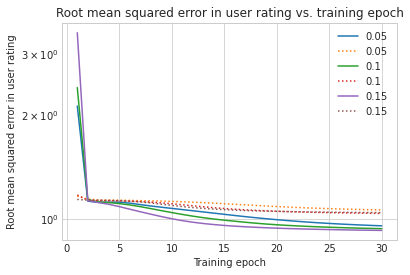

In [ ]:
for val in learning_rates_linear:
    lr = str(val)
    plt.plot(epochs_x, histories_tr_li[lr].history['root_mean_squared_error'], label=lr)
    plt.plot(epochs_x, histories_tr_li[lr].history['val_root_mean_squared_error'], label=lr, linestyle='dotted')

plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.yscale('log')
plt.legend()

The best performances for the linear grid search look quite similar to each other, so let's stick with learning rate 0.1 and train the final model.

In [ ]:
model_tr = MovielensModelTunedRanking()
model_tr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
history_tr = model_tr.fit(cached_train, epochs=50, validation_data=cached_validation)

Epoch 1/50
8/8 [==============================] - 1s 30ms/step - root_mean_squared_error: 2.3640 - loss: 5.1172 - regularization_loss: 1.9729 - total_loss: 7.0902 - val_root_mean_squared_error: 1.1673 - val_loss: 1.3654 - val_regularization_loss: 1.8838 - val_total_loss: 3.2491
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.1214 - loss: 1.2550 - regularization_loss: 1.7940 - total_loss: 3.0491 - val_root_mean_squared_error: 1.1339 - val_loss: 1.2881 - val_regularization_loss: 1.7036 - val_total_loss: 2.9917
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - root_mean_squared_error: 1.1120 - loss: 1.2346 - regularization_loss: 1.6250 - total_loss: 2.8596 - val_root_mean_squared_error: 1.1319 - val_loss: 1.2833 - val_regularization_loss: 1.5437 - val_total_loss: 2.8270
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - root_mean_squared_error: 1.1028 - loss: 1.2141 - regularization_loss: 1.4733 - total_loss: 2.6873 

In [ ]:
rmse_tr = history_tr.history['root_mean_squared_error'][-1]
print(f'Root mean squared error in user rating from training: {rmse_tr:.2f}')

val_rmse_tr = history_tr.history['val_root_mean_squared_error'][-1]
print(f'Root mean squared error in user rating from validation: {val_rmse_tr:.2f}')

Root mean squared error in user rating from training: 0.92
Root mean squared error in user rating from validation: 1.04


In [ ]:
num_validation_runs = len(history_tr.history['root_mean_squared_error'])
validation_freq = 1
epochs_x = [(x + 1) * validation_freq for x in range(num_validation_runs)]

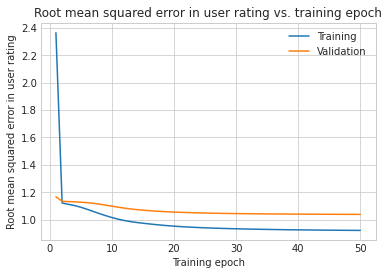

In [ ]:
plt.plot(epochs_x, history_tr.history['root_mean_squared_error'], label='Training')
plt.plot(epochs_x, history_tr.history['val_root_mean_squared_error'], label='Validation')
plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.legend()

As mentioned, this is a very basic hyperparameter tuning. Some obvious improvements to this use of a grid for tuning include:

- Use a larger grid of learning rates (log + linear fine-tuning)
- More epochs in model.fit(): 100s, not 30 or 50
- Use `keras.tuner` and/or TensorFlow callbacks to retain the best model, and retrain it with both the training and validation data once found
- Use callbacks to stop training when the improvement rate drops below a threshold (early stopping), instead of training for a fixed number of epochs
- Tune layer size or number of layers, as in [the TFRS multitask tutorial](https://www.tensorflow.org/recommenders/examples/multitask)
- Tune the L2 regularization factor, currently set to the default 0.01
- The [regularizer](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting) can be dropout as well as L2 (aka. weight decay), or it can be both
- Tune embedding size (vary the number of dimensions from 32 and the number of  categories that can be fit: more is better unless it causes overfitting or too-slow training)
- Optimizers other than Adagrad, e.g., SGD, RMSprop, Adam, Nadam
- Activation functions other than ReLU, e.g., SELU with LecunNormal weight initialization
- Keras tuner or [TensorBoard HParams](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) for multi-parameter search, or smart search. The I/O would need to match the recommender model, but often smart search will find better hyperparameter sets then manual tuning, even by experts
- Add [other metrics](https://www.tensorflow.org/guide/effective_tf2#tfmetrics_aggregates_data_and_tfsummary_logs_them) besides RMSE to the plotted tuning history

One thing that is clear from the above code, however, is that managing and plotting much more extensive tuning from a single notebook can quickly become unwieldy, error-prone, and hard to reproduce due to the combinatorial explosion of parameters and their differing types and amounts. So the desirability of eking out further model performance needs to be balanced against this.

There are various further improvements beyond tuning that should therefore also be considered - see the appendix.

As in previous sections, we can see a summary of the final model architecture.

In [ ]:
model_tr.summary()

Model: "movielens_model_tuned_ranking_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 32)                53280     
_________________________________________________________________
sequential_25 (Sequential)   (None, 32)                30208     
_________________________________________________________________
sequential_26 (Sequential)   (None, 1)                 33153     
_________________________________________________________________
ranking_8 (Ranking)          multiple                  2         
Total params: 116,643
Trainable params: 116,641
Non-trainable params: 2
_________________________________________________________________


As with the basic model, the performance of the model on the unseen testing data is similar to the validation performance, at about RMSE ~ 1.

In [ ]:
eval_tr = model_tr.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 4ms/step - root_mean_squared_error: 1.0260 - loss: 1.0544 - regularization_loss: 0.0727 - total_loss: 1.1271


In [ ]:
rmse_eval_tr = eval_tr['root_mean_squared_error']
print(f'Root mean squared error in user rating from evaluation: {rmse_eval_tr:.2f}')

Root mean squared error in user rating from evaluation: 1.03


And as above, new data can now be sent to the model.

In [ ]:
# Again returns the embeddings and predicted ratings
model_tr.predict(cached_test)

(array([[ 0.02849846,  0.0176121 , -0.00894195, ..., -0.04526925,
         -0.01119535,  0.00639677],
        [-0.04739385,  0.03865167,  0.02980467, ...,  0.0179348 ,
          0.03060083, -0.02724645],
        [ 0.01094703, -0.01979085, -0.01319928, ..., -0.00660934,
         -0.00511613,  0.00533506],
        ...,
        [-0.0411031 ,  0.00898093, -0.04372801, ..., -0.03874222,
         -0.02124953, -0.02406938],
        [-0.00822344, -0.02573305,  0.04053061, ...,  0.01533296,
          0.04250797, -0.0078328 ],
        [-0.0378443 ,  0.022497  ,  0.00351272, ..., -0.01329498,
         -0.02220261, -0.01760115]], dtype=float32),
 array([[ 0.02721014,  0.02484442,  0.0145153 , ..., -0.04539186,
          0.07511394,  0.06882158],
        [ 0.06826174,  0.00559263, -0.01384696, ..., -0.04238057,
         -0.00072053,  0.0022185 ],
        [ 0.05204289,  0.04300666,  0.01135077, ..., -0.01102841,
          0.04134514,  0.03032939],
        ...,
        [ 0.03491384,  0.00594732,  0.0

### 4.3: Model as Gradient Workflow

**This section requires the user to input their settings - see below.**  
**Gradient Workflows is still a maturing product and it is expected that all of the setup steps currently given here will disappear in time.**

Having completed creating and training the models in our notebook here, in principle we have a model that can be deployed into production.

What can be seen from the above, however, is that even though we only trained 3 models - the wide grid, narrow grid, and final, already the notebook is quite long, and there are quite a few loops and things to keep track of. Adding further models, data preparation, feature engineering, etc., will quickly result in this getting out of hand, with too many things to keep track of. Considering that a typical real project might have 100s of models, when we get to that scale, a more rigorous way of working is indicated.

There are good reasons to start with a notebook, which is why we have done so here, but when a project gets large, we can switch from Gradient's Notebook way of working to its Workflows. This does, however, require more setup and structure than a notebook.

This section shows an example of a Workflow, where we put the code we need into a script, and instead of training the model from the notebook, we run that. Our script is `workflow_train_model.py`, and we show training the final model from section 4.2 above. The code is a subset of the notebook, with a few minor changes for lines that work in cells but not a .py (or vice versa), for example, `!pip install -q tensorflow-recommenders==0.4.0` becomes `subprocess.run('pip install -q tensorflow-recommenders==0.4.0', shell=True, check=True, stdout=subprocess.PIPE, universal_newlines=True)`. Another example would be `%` or `%%` line and cell magics.

Since they run via script and parameter files (YAML), Workflows can be used without requiring a notebook at all. Here, to preserve continuity and keep the project within one end-to-end setting, we call the Workflow from the notebook. This involves setting up access to it and calling the YAML file with the settings, which in turn calls `workflow_train_model.py`.

Aside from the advantages or organization, reproducibility, etc., Gradient also allows the setup to be straightforwardly extended to using GPU instead of CPU, by choosing a GPU instance, and using multiple machines instead of a single machine, by using multinode instead of single node. Since Gradient can use the Paperspace infrastructure, the user does not need to set up their own GPUs or be an expert in distributed computing to access this power.

#### Workflow setup

To run the Workflow requires the user to supply the following settings:

 - `api_key` = API key to access Gradient. This is part of setting up one's user account
 - `workflow_train_id` = Currently Workflows need to be created in the GUI or CLI
 - `workflow_deploy_id` = Similarly for deployment Workflow in section 5
 
To obtain these, follow the steps under *Additional requirements to run Gradient Workflows and model deployment (sections 4.3+)* near the start of the notebook.

If you are using a Gradient private cluster, you should also specify `cluster_id`. If cluster ID is not specified, the Gradient public cluster will be used.

When all is set up, add your settings to the next cell, then run it.

They will look similar to this:

`cluster_id = 'cdefghijk'` (optional)  
`workflow_id_train = '6789abcd-01ef-23gh-45ij-678901klmnop'`  
`workflow_id_deploy = '6789abcd-01ef-23gh-45ij-678901klmnoq'`

In [ ]:
workflow_id_train = '6c325f57-9979-402e-8560-fe09951990cc' # Created workflows in GUI/CLI
workflow_id_deploy = '1f116f34-388e-4e47-8f47-570cd2218795'

The API key could also be given here as a string, but since it is a credential that allows access to the system for you as a user, it is better to not do so. Gradient will in future support accessing its Secrets from the Notebook via the SDK. For now, we can read the key, supplied by the user, from a file. Best is to create key.txt with the key in it, upload it here, then delete when done. The API key looks like `0123456789abcdef0123456789abcd`.

In [ ]:
file = './key.txt'

with open(file) as f:
    out = f.readlines()

api_key = ''.join(out).strip('\n')

#### Access Gradient
Aside from its graphical interface (GUI), Gradient has command line and SDK interfaces that allow interaction to achieve most of the same things that can be done with the GUI. The lines here set up access to the SDK.

Here, we install the Gradient SDK using pip. If you are running the notebook on your own machine rather than the Gradient Notebook, then this will also work.

In [ ]:
!pip install -U gradient # -U means upgrade any existing installed packages that this would have installed

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.0 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.
tensorflow-gpu 2.4.1 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.


Functionality such as Workflows and deployments are under `SdkClient`. Aside from the ones shown, there are about [20 more](https://paperspace.github.io/gradient-cli/gradient.api_sdk.clients.html).

In [ ]:
# Access Gradient from the SDK, i.e., this notebook
from gradient import sdk_client

# Enable SDK to access YAML file
import yaml

# SDK clients
# All can be accessed from client, or shorthanded for convenience as here
client = sdk_client.SdkClient(api_key)
deployments_client = sdk_client.DeploymentsClient(api_key)
workflows_client  = sdk_client.WorkflowsClient(api_key)

When running workflows in Gradient, they can be associated with a user's project, which here we created above as part of the currently required manual setup steps.

In other notebooks, you may want to create a project from the notebook, which can be done with

`project_id = client.projects.create('My project')`

With a project ID, you can also see information about project contents, such as the workflows

`workflows = workflows_client.list(project_id=project_id)
print(workflows)`

After a project is created, it will also be visible under the Projects tab in the GUI, and to the command line.

#### Run the Workflow

Now we are setup, we can run the Workflow by referring to its YAML file, `workflow-train-model.yaml`. Use of YAML is part of what makes this production-grade, as opposed to just for experimenting.

The YAML file contains two jobs: `CloneRepo` and `RecommenderTrain`. The first one accesses the GitHub repository to obtain the training script, and the second runs the model training. For more details about YAML, see part 4 of the blog series, and the [Workflows documentation](https://docs.paperspace.com/gradient/explore-train-deploy/workflows).

In [ ]:
# Train model
spec_path = './workflow-train-model.yaml'

yaml_spec = open(spec_path, 'r')
train_spec = yaml.safe_load(yaml_spec)

# If you are using a Gradient private cluster, add the cluster_id here as another argument
workflow_param_train = {
    'workflow_id' : workflow_id_train,
    'spec': train_spec,
    'inputs': None
}

workflow_run_train = workflows_client.run_workflow(**workflow_param_train) # "**" is used because parameters is a dictionary

If you have your team name, project ID, and Workflow ID, you can access the Workflow directly at its URL in the GUI:

`https://console.paperspace.com/<team name>/projects/<project_id>/workflows/<workflow ID>`

e.g., like

`https://console.paperspace.com/my_team/projects/pqrstuvwx/workflows/6789abcd-01ef-23gh-45ij-678901klmnop`

Or navigate there via the Workflows tab.

Information about the Workflow can also be retrieved from the output of its invocation above (`workflow_run_train`).

In [ ]:
workflow_run_train

{'id': 10,
 'cluster': {'id': 'clg07azjl'},
 'spec': {'jobs': {'CloneRecRepo': {'uses': 'git-checkout@v1',
    'with': {'url': 'https://github.com/gradient-ai/Deep-Learning-Recommender-TF'},
    'outputs': {'repoRec': {'type': 'volume'}}},
   'RecommenderTrain': {'env': {'HP_FINAL_LR': '0.1', 'HP_FINAL_EPOCHS': '50'},
    'uses': 'script@v1',
    'with': {'image': 'tensorflow/tensorflow:2.4.1-jupyter',
     'script': 'cp -R /inputs/repoRec /Deep-Learning-Recommender-TF\ncd /Deep-Learning-Recommender-TF\npython workflow_train_model.py'},
    'needs': ['CloneRecRepo'],
    'inputs': {'repoRec': 'CloneRecRepo.outputs.repoRec'},
    'outputs': {'trainedRecommender': {'type': 'dataset',
      'with': {'ref': 'recommender'}}}}},
  'defaults': {'env': {'PAPERSPACE_API_KEY': 'secret:api_key_recommender'},
   'resources': {'instance-type': 'P4000'}}},
 'status': {'phase': 'SUBMITTING',
  'logId': 'wfr5574a82d07a24e11ac423cdfbefdd042',
  'jobs': {'RecommenderTrain': {'phase': 'SUBMITTING',
    '

Like most Gradient functionality, invoking the Workflow from the GUI or SDK has an equivalent in the command line. Here we don't run it, since it would just rerun the same computation, but for reference, it is:

`gradient workflows run \`  
`  --id <workflow_id_train> \`  
`  --clusterId <cluster_id> \`  
`  --path <path_to_yaml_file>`

i.e., like

`gradient workflows run \`  
` --id 6789abcd-01ef-23gh-45ij-678901klmnop \`  
` --clusterId cdefghijk \`  
` --path ./workflow-train-model.yaml`
  
There are other parameters available which we did not use here. See the [API documentation on Workflows](https://paperspace.github.io/gradient-cli/gradient.api_sdk.clients.html#module-gradient.api_sdk.clients.workflow_client) for information on those, and the [command line](https://paperspace.github.io/gradient-cli/gradient.cli.html) section under Workflows for more on CLI equivalents.

# NOT YET SUPPORTED HERE TO END

Section 5 is pending support of model deployment from Workflows, and availability of deployments on public clusters. These will both be available circa Q4 2021, so we show the rest of the Notebook for completeness, but it will not yet run correctly.

## 5: Deploy the final model

A major part of any production data science end-to-end dataflow is that the trained model must be deployed so that it can generate output on new data being fed to it (inference). Many enterprise projects fail at the production stage, even if a model was successfully trained and showed good performance.

In this project, the necessity of using a lower level model representation, i.e., the subclassing API, for recommender systems also adds to the potential complexity of deployment. Solving many real business problems will also require the subclassing API because of some custom requirement or business logic, and face similar issues.

While it is possible to take one or more of the models generated from the notebook in sections 4.1 and 4.2 above, and then setup TensorFlow Serving to deploy, the process is so much easier on Gradient that we do not attempt this, and instead go directly to deploying the final model from section 4.3.

In an enterprise production system, after model deployment comes dealing with model output to make it actionable to the business, model monitoring (especially for concept / data / model drift), retraining or updating the model when it does drift, and periodic updates with stakeholders to be sure the model is still being used and providing value. Some of these are mentioned again in the appendices below regarding improvements to the analysis and extensions to the project.

### 5.1: Create and start model deployment using Workflows

Running `workflow_train_model.py` from section 4.3 above produces a saved model, which we will deploy here.

For reference, the lines in the Workflow's `workflow_train_model.py` to save the model are the standard `model.save` form from TensorFlow. The output directory is the location specified in the `workflow-train-model.yaml` file

`export_path = '/outputs/trainedRecommender'`  
`print('export_path = {}\n'.format(export_path))`  
`model_tr.save(export_path)`

Viewing this in the GUI, one can see that the model is on disk and has the usual TensorFlow SavedModel structure:

 - `saved_model.pb` = code for the model, including its architecture
 - `variables/` = trained model weights
 - `assets/` = internal information for restoring the model if needed, here empty so not shown. An example would be a text file for initializing a vocabulary.
 
The model is present and ready to be deployed. The process is similar to running the training, and shows the advantage of using this setup: the machine, cluster configuration, and container are all already available, and the deployments will be organized and versioned similar to how the models are.

As with the training, there is a corresponding YAML file, `workflow-deploy-model.yaml` that here contains 3 jobs: `UploadModel`, `CreateDeployment`, and `StartDeployment`. `UploadModel` accesses the desired model version and makes it accessible to the Workflow, then create and start are separate steps since in general not all created deployments will want to be started immediately, and a deployment may want to be stopped without being deleted.

Unlike the training, in the deployment here, a further `.py` Python script is not needed.

As with training, there are more parameters available, as described in the [API documentation for deployment creation](https://paperspace.github.io/gradient-cli/gradient.api_sdk.clients.html#module-gradient.api_sdk.clients.deployment_client).

In [ ]:
spec_path = './workflow-deploy-model.yaml'

yaml_spec = open(spec_path, 'r')
deploy_spec = yaml.safe_load(yaml_spec)

workflow_param_deploy = {
    'workflow_id' : workflow_id_deploy,
    'spec': deploy_spec,
    'inputs': None
}

workflow_run_deploy = workflows_client.run_workflow(**workflow_param_deploy)

As with training, we can view the deployment details.

In [ ]:
workflow_run_deploy

### 5.2: Send predictions to the model

When a model is deployed with Gradient Deployments (or TensorFlow Serving), there is a choice between using the Google gRPC API and the http [REST API](https://www.tensorflow.org/tfx/serving/api_rest#predict_api).

Here, we use the REST API.

With this API, to send new data (requests) to the deployed model, and have it return predicted movie ratings for that data (predictions), the requests must be formatted as JSON rather than TensorFlow tensors. So we can't just use the same format as the loaded TFDS dataset, or the `cached_train` that we passed in during training above.

As a reminder, the raw data loaded in looked like this:

In [ ]:
for x in ratings_raw.take(2).as_numpy_iterator():
    pprint.pprint(x)

and the data passed to the model during training looked like this:

In [ ]:
for x in cached_train.take(2).as_numpy_iterator():
    pprint.pprint(x)

But for JSON, the data needs to look more like this:

```
{
 "instances": [
   {
     "tag": "foo",
     "signal": [1, 2, 3, 4, 5],
     "sensor": [[1, 2], [3, 4]]
   },
   {
     "tag": "bar",
     "signal": [3, 4, 1, 2, 5]],
     "sensor": [[4, 5], [6, 8]]
   }
 ]
}
```

From [the TFX API page](https://www.tensorflow.org/tfx/serving/api_rest#specifying_input_tensors_in_row_format): "For multiple named inputs, each item is expected to be an object containing input name/tensor value pair, one for each named input. ... a request with two instances, each with a set of three named input tensors".

To create JSON-formatted data, the easiest way at the scale of data in this notebook is to use Python's json module. Then to send it, the requests module is used to enable it to be sent to the REST API via POST.

In [ ]:
import requests
import json

The correct format of a some data rows (instances) then looks like this:

In [ ]:
test_rows_1 = {'movie_title': 'Devils Advocate, The (1997)',
 'timestamp': 892870992,
 'user_id': '587'}

test_rows_2 = {'movie_title': 'Donnie Brasco (1997)',
 'timestamp': 891499278,
 'user_id': '782'}

test_rows_3 = {'movie_title': 'Craft, The (1996)',
 'timestamp': 891700850,
 'user_id': '280'}

And it can be converted to JSON with .dumps (dump string), with the instances as a list.

In [ ]:
data = json.dumps({'signature_name': 'serving_default', 'instances': [test_rows_1, test_rows_2, test_rows_3]})
data

Then the data can be sent to the deployed model via POST, and the returned output extracted from the full response by `.json()`. We can get the model's endpoint from the deployment properties, as shown above.

In [ ]:
endpoint = deployment[0].endpoint
headers = {'content-type': 'application/json'}
json_response = requests.post(endpoint, data=data, headers=headers)
pprint.pprint(json_response.json(), compact=True)

As with `.predict()` in training above, this has returned both the embeddings and the predictions. We can also extract just the predictions.

In [ ]:
predictions = json.loads(json_response.text)['predictions']

print(predictions[0]['output_3'])
print(predictions[1]['output_3'])
print(predictions[2]['output_3'])

One thing to note about the above of course is that we wrote the example lines of new data here to send to the model, instead of loading them. This could be improved by, say loading more data from TFDS. In this particular case, more steps would be required in converting the byte-encoded fields into the above format before passing to JSON, because byte-encoded fields are not JSON serializable.

### 5.3: Stop deployment

Once we are done with the deployment, we can stop it again to avoid leaving it consuming compute resources.

In [ ]:
deployments_client.stop(deployment_id)

## 6: Conclusions

We have shown an end-to-end example of deep learning recommender models in TensorFlow, using the TensorFlow Recommenders (TFRS) library, and the implementation of this using Paperspace Gradient.

The main takeaways are:

 - We showed a real-world-style example of machine learning on Gradient
 - This is within an end-to-end dataflow incorporating both Gradient Notebooks and Workflows
 - Modern data science methodology based on Gradient's integrations with Git was used
 - We used TensorFlow 2 and TensorFlow Recommenders (TFRS) to train a recommender model that includes deep learning
 - We used training data that reflects what real-world projects deal with (not just demo data)
 - We constructed a custom model using the full TensorFlow subclassing API
 - Feature engineering and hyperparameter tuning improved model performance versus a basic model (RMSE between predicted and user ratings from ~ 1.1 to ~ 1)
 - The model was deployed using Gradient Deployments and its TensorFlow Serving integrations
 - Accompanying material is available: the 6 part blog series, and Git repository
 - We have aimed at a broad technical audience: data scientists who are not engineers, engineers who are not data scientists, those who span the two disciplines, and others

The project is not a complete enterprise-grade recommender system: they would typically take teams of several people months to construct, but it aims to be more than just a simple demonstration or toy model, by showcasing real data science techniques.

# Next steps

Now that you have seen recommender systems, deep learning, and Paperspace Gradient, if you are interested in taking some next steps, some options are:

 - Sign up for [Paperspace](https://paperspace.com), if not done already
 - Run this notebook on [Gradient](https://gradient.paperspace.com), if not done already
 - Read the accompanying [blog series](https://blog.paperspace.com) to this notebook
 - See more projects on our [ML Showcase](https://ml-showcase.paperspace.com)
 - View the Gradient [documentation](https://docs.paperspace.com) or [API reference](https://paperspace.github.io/gradient-cli)
 - Learn more about recommenders at [TFRS](https://www.tensorflow.org/recommenders)
 - Check out more links and references in the [final part]() of the blog
 - [Contact sales](https://info.paperspace.com/contact-sales)

# Appendices

These show ways the project can be extended, either generically, or in ways specifically aided by Paperspace Gradient.

## Appendix 1: Improvements to the analysis

These are some ways that the analysis could be improved while telling the same story. These are given in the order in which they would appear in the dataflow.

They are relatively briefly described here. For more details, see the final part of the blog.

A few minor detail improvements were also included in various code comments throughout the notebook.

 - Add more to the business story: here it is showing the generic concept of a deep learning recommender improving upon a basic model, but it is not translated into specific quantified business value for a given use case.
 - Use a bigger dataset: Aside from movielens-100k, the available datasets include 1M, 20M, and 25M. 20M and 25M contain less demographic information but still include user ratings.
 - Data larger than 25M can be produced via simulation if we wish to show scaling to bigger sizes, e.g., the [original MovieLens site](https://grouplens.org/datasets/movielens) contains a synthetic dataset called MovieLens-1B, which can go to numbers of interactions in the billions.
 - Add data exploration for information and sanity checking.
 - Use more [features](https://www.tensorflow.org/recommenders/examples/featurization) and [context](https://www.tensorflow.org/recommenders/examples/context_features) from the dataset to improve model performance, including preprocessing with word embedding, text tokenization, normalizaton of numerical values, and timestamps.
 - Feature selection / engineering, e.g., day of week or time of day.
 - Hyperparameter tuning improvements noted in section 4.2 above.
 - Turning metric calculation off in training for [retrieval models](https://www.tensorflow.org/recommenders/examples/basic_retrieval) (compute_metrics in task as False) can make training faster.
 - Examine the model output predicted ratings in more detail - most are currently around 3-4, and since most reviews are 3-5 out of 5, just saying 3.5ish every time might give the best RMSE.
 - Remove all randomness in execution of the ML models, making their results exactly reproducible. This may not be possible in some environments such as a distributed system.
 - Use Paperspace's GPU instances for faster training of large models.

## Appendix 2: Extensions to the project

These are possible extensions to the analysis that would add to the story, again in approximate dataflow order.

### Generic

 - Address [fairness, bias, etc.](https://www.tensorflow.org/tfx/guide/fairness_indicators), in feature selection and model training.
 - Show dealing with missing data and out-of-vocabulary categoricals.
 - Show improving performance via [feature crosses](https://www.tensorflow.org/recommenders/examples/dcn).
 - Add the retrieval model and hence a [combined model](https://www.tensorflow.org/recommenders/examples/multitask) for both retrieval and ranking.
 - Show dealing with the "cold start" problem of what to recommend to a new user who hasn't watched any movies but whose information we possess.
 - Use data from common tasks to help model rarer tasks via transfer learning.
 - Add an option to exclude already-watched shows or movies from a user's recommendations, or add extra variety versus the baseline choices.
 - Visualize the trained model with TensorBoard or [TFMA](https://www.tensorflow.org/tfx/model_analysis/metrics).
 - Provide [explanations](https://www.tensorflow.org/recommenders/examples/dcn) for the models' choices of recommendations.
 - For retrieval, deploy with [ScaNN approximate nearest neighbors](https://www.tensorflow.org/recommenders/examples/efficient_serving) to speed up model inference. Tune the layer for better performance/accuracy tradeoff.
 - Monitor the deployed model for drift and/or anomalies using a monitoring tool.

### Paperspace Gradient-specific

 - Show the relation between working in Notebooks, Workflows, and Gradient's GradientCI GitHub integration capabilities, e.g., versioning of notebooks, when they are supported by Workflows.
 - Show getting the data from somewhere that is not TensorFlow's prepackaged datasets (TFDS), that Gradient easily connects to, e.g., Amazon S3.
 - Show distributed training with Gradient's multinode capability.
 - Combine multinode, GPU, and GradientCI to show distributed GPU training that follows good versioning practices and GitHub integration.
 - Show full specification of the end-to-end data flow (software, versions, licenses, security) in a way that makes it easy for an enterprise IT department to approve it.
 - Show production of an audit trail from the end-to-end process, making it auditable and hence FAccT (fair, accountable, and transparent).
 - Show how other users can query the deployed model.
 - Show retraining being triggered with Gradient's jobs function, e.g., if deployed model has drifted.
 - Show rollback to an earlier deployed model.
 - Show a GUI application (e.g., Streamlit) that accesses the deployed model's API endpoint, making its functionality accessible to non-technical as well as technical users.